In [224]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,f1_score
from sklearn.metrics import accuracy_score 
from xgboost import XGBClassifier

In [225]:
df = pd.read_csv("adult.csv")

In [226]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


### Fix the data if needed.

In [227]:
attrib, counts = np.unique(df['workclass'], return_counts = True)
most_freq_ = attrib[np.argmax(counts, axis = 0)]
df['workclass'][df['workclass'] == '?'] = most_freq_

attrib, counts = np.unique(df['occupation'], return_counts = True)
most_freq_ = attrib[np.argmax(counts, axis = 0)]
df['occupation'][df['occupation'] == '?'] = most_freq_

attrib, counts = np.unique(df['native-country'], return_counts = True)
most_freq_ = attrib[np.argmax(counts, axis = 0)]
df['native-country'][df['native-country'] == '?'] = most_freq_

<ipython-input-227-c7badfdb332b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['workclass'][df['workclass'] == '?'] = most_freq_
<ipython-input-227-c7badfdb332b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['occupation'][df['occupation'] == '?'] = most_freq_
<ipython-input-227-c7badfdb332b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['native-country'][df['native-country'] == '?'] = most_freq_


In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [229]:
object_describe=df.describe().T
object_describe

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
educational-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


### Let's see the count??

### Observe the trend of income vs occupation ?

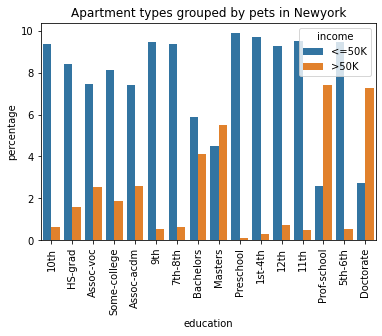

In [230]:
occupation_counts = df.groupby(['education'])['income'].value_counts(normalize=True).rename('percentage').mul(10).reset_index().sort_values('income')
p = sns.barplot(x="education", y="percentage", hue="income", data=occupation_counts)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.title("Apartment types grouped by pets in Newyork")
plt.savefig("Apartment types grouped by pets in Newyork")

#### We can clearly see the bachelor and Master degree has approximately equal number of >50k and <50k. Only for the doctorate the total count is <50k. For other like high school and less the income is less than 50k. The data speaks the commons sense.

### Biased in the income

In [231]:
df.income.value_counts(normalize = True)

<=50K    0.760718
>50K     0.239282
Name: income, dtype: float64

In [232]:
df.gender.value_counts(normalize = True)

Male      0.668482
Female    0.331518
Name: gender, dtype: float64

In [233]:
df.groupby('income')['gender'].value_counts(normalize = True)

income  gender
<=50K   Male      0.611815
        Female    0.388185
>50K    Male      0.848635
        Female    0.151365
Name: gender, dtype: float64

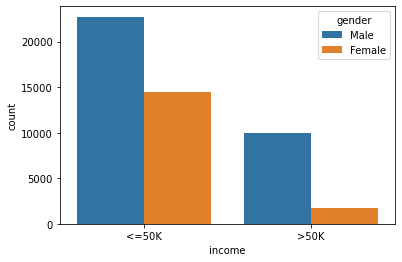

In [234]:
ax = sns.countplot(x="income", data=df, hue = 'gender')

#### The number of males number is much higher, also count of the <50k is more than 75% compare to >50k. The data of this part is highly biased.

### See the marital status with the income

In [235]:
df['marital-status'].value_counts(normalize = True)

Married-civ-spouse       0.458192
Never-married            0.329982
Divorced                 0.135805
Separated                0.031325
Widowed                  0.031080
Married-spouse-absent    0.012858
Married-AF-spouse        0.000758
Name: marital-status, dtype: float64

#### Fix the married-spouse-absent as the seperated

In [236]:
df['marital-status'][df['marital-status'] == 'Married-spouse-absent'] = 'Separated'

<ipython-input-236-76388d690338>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['marital-status'][df['marital-status'] == 'Married-spouse-absent'] = 'Separated'


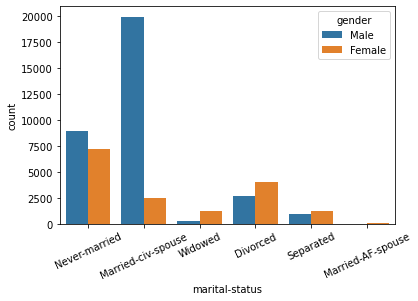

In [237]:
ax = sns.countplot(x="marital-status", data=df, hue = 'gender')
plt.xticks(rotation=25)
plt.show()

#### Male count of Married-civ-spuose is huge compare to Female in the data, again one of the bias.

<AxesSubplot:>

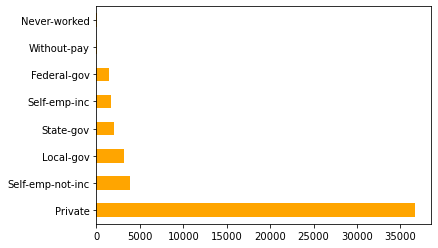

In [238]:
df["workclass"].value_counts().plot.barh(color="orange")

#### Not just biased in the income <50k and >50k but also in the workclass. Private sector count is significanly higher .

### Can I make a scatterplot? 

In [239]:
df_new

,age,fnlwgt,education,educational-num,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,gender_Female,gender_Male
0,25,226802,11th,7,0,0,40,<=50K,0,0,...,0,0,0,0,0,1,0,0,0,1
1,38,89814,HS-grad,9,0,0,50,<=50K,0,0,...,0,0,0,0,0,1,0,0,0,1
2,28,336951,Assoc-acdm,12,0,0,40,>50K,0,1,...,0,0,0,0,0,1,0,0,0,1
3,44,160323,Some-college,10,7688,0,40,>50K,0,0,...,0,0,0,0,0,1,0,0,0,1
4,18,103497,Some-college,10,0,0,30,<=50K,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,257302,Assoc-acdm,12,0,0,38,<=50K,0,0,...,0,0,0,0,0,1,0,0,1,0
48838,40,154374,HS-grad,9,0,0,40,>50K,0,0,...,0,0,0,0,0,1,0,0,0,1
48839,58,151910,HS-grad,9,0,0,40,<=50K,0,0,...,0,0,0,0,0,1,0,0,1,0
48840,22,201490,HS-grad,9,0,0,20,<=50K,0,0,...,0,0,0,0,0,1,0,0,0,1


### Why capital gain and loss zero , are they alternating, when loss gain is zero and vice-versa?

In [240]:
df_loss=df.loc[df["capital-loss"]!=0,:]
df_loss.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
52,21,Private,214399,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,1721,24,United-States,<=50K
82,24,Private,83141,Some-college,10,Separated,Other-service,Not-in-family,White,Male,0,1876,40,United-States,<=50K
129,41,Private,239296,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,2415,50,United-States,>50K
143,43,Self-emp-inc,214503,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,45,United-States,>50K
154,40,State-gov,67874,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,1887,45,United-States,>50K


In [241]:
df_loss=df.loc[df["capital-gain"]!=0,:]
df_loss.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
10,65,Private,184454,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,6418,0,40,United-States,>50K
14,48,Private,279724,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,3103,0,48,United-States,>50K
25,45,Self-emp-not-inc,432824,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7298,0,90,United-States,>50K


<AxesSubplot:xlabel='hours-per-week', ylabel='capital-gain'>

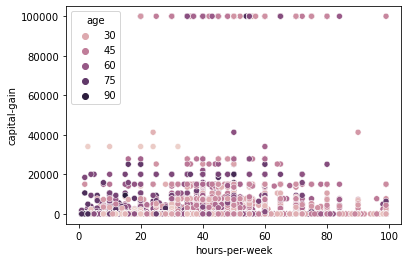

In [242]:
sns.scatterplot(data=df, x="hours-per-week", y="capital-gain", hue ='age')

<AxesSubplot:xlabel='hours-per-week', ylabel='capital-loss'>

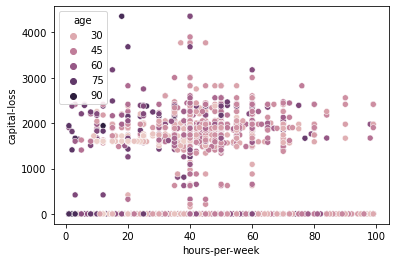

In [243]:
sns.scatterplot(data=df, x="hours-per-week", y="capital-loss", hue = 'age')

### Can I make a correlational plot?

<AxesSubplot:>

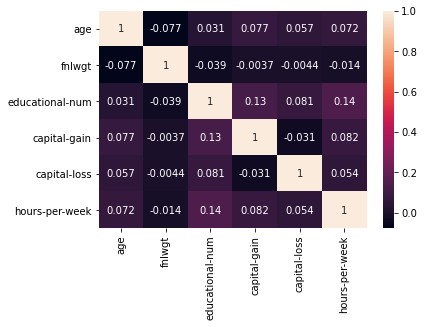

In [244]:
corr=df.corr()
sns.heatmap(corr,annot=True)

### Can we see the outlier ?

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/si

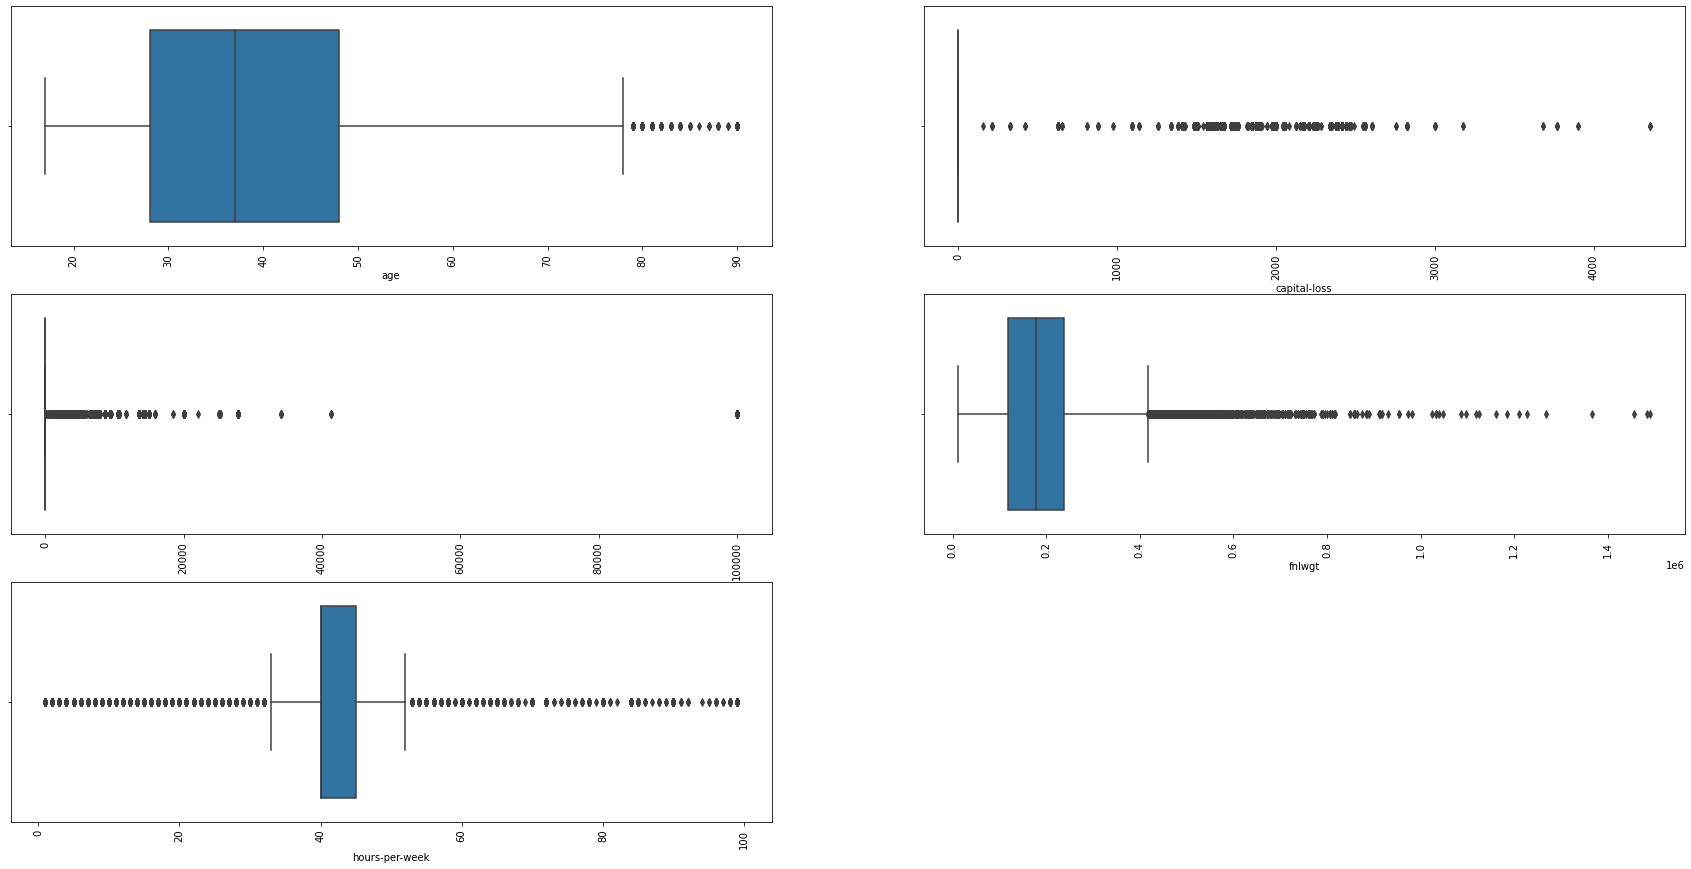

In [245]:
plt.figure(figsize=(30,15))

plt.subplot(321)
sns.boxplot(df["age"])
plt.xticks(rotation=90)

plt.subplot(322)
sns.boxplot(df["capital-loss"])
plt.xticks(rotation=90)

plt.subplot(323)
sns.boxplot(df["capital-gain"])
plt.xticks(rotation=90)

plt.subplot(324)
sns.boxplot(df["fnlwgt"])
plt.xticks(rotation=90)

plt.subplot(325)
sns.boxplot(df["hours-per-week"])
plt.xticks(rotation=90)
plt.show()

### Can we built the model to classify the income ?

In [246]:
df.describe(include = ['object']).T

,count,unique,top,freq
workclass,48842,8,Private,36705
education,48842,16,HS-grad,15784
marital-status,48842,6,Married-civ-spouse,22379
occupation,48842,14,Prof-specialty,8981
relationship,48842,6,Husband,19716
race,48842,5,White,41762
gender,48842,2,Male,32650
native-country,48842,41,United-States,44689
income,48842,2,<=50K,37155


In [247]:
df_new=pd.get_dummies(df,columns=["workclass","marital-status","occupation","relationship","race","native-country", "gender"])

In [248]:
df_new

,age,fnlwgt,education,educational-num,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,gender_Female,gender_Male
0,25,226802,11th,7,0,0,40,<=50K,0,0,...,0,0,0,0,0,1,0,0,0,1
1,38,89814,HS-grad,9,0,0,50,<=50K,0,0,...,0,0,0,0,0,1,0,0,0,1
2,28,336951,Assoc-acdm,12,0,0,40,>50K,0,1,...,0,0,0,0,0,1,0,0,0,1
3,44,160323,Some-college,10,7688,0,40,>50K,0,0,...,0,0,0,0,0,1,0,0,0,1
4,18,103497,Some-college,10,0,0,30,<=50K,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,257302,Assoc-acdm,12,0,0,38,<=50K,0,0,...,0,0,0,0,0,1,0,0,1,0
48838,40,154374,HS-grad,9,0,0,40,>50K,0,0,...,0,0,0,0,0,1,0,0,0,1
48839,58,151910,HS-grad,9,0,0,40,<=50K,0,0,...,0,0,0,0,0,1,0,0,1,0
48840,22,201490,HS-grad,9,0,0,20,<=50K,0,0,...,0,0,0,0,0,1,0,0,0,1


In [249]:
X=df_new.drop(columns=["income", "education"],axis=1)
X["educational-num"]=X["educational-num"].astype("int")

In [251]:
y = df_new['income']

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [259]:
xgb=XGBClassifier(seed=42,max_depth=7)
xgb_model=xgb.fit(X_train,y_train)
y_pred=xgb_model.predict(X_test)

xgb_train_score=xgb_model.score(X_train,y_train)
xgb_accuracy_score=accuracy_score(y_test,y_pred)
xgb_f1_score=f1_score(y_test,y_pred, pos_label=">50K")

[01:08:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [264]:
xgb_train_score, xgb_accuracy_score, xgb_f1_score

(0.9085380760298252, 0.8765355503164164, 0.7170884276371907)

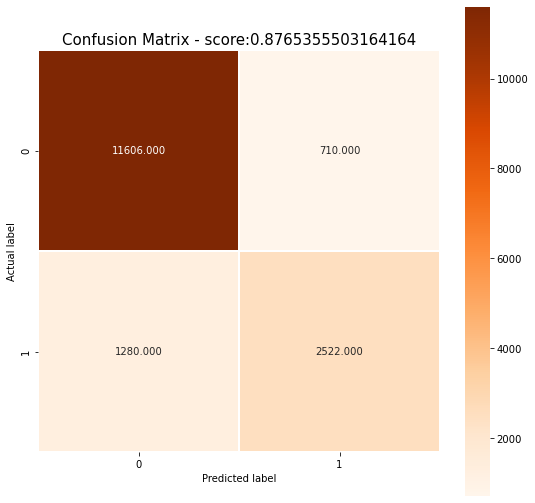

              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92     12316
        >50K       0.78      0.66      0.72      3802

    accuracy                           0.88     16118
   macro avg       0.84      0.80      0.82     16118
weighted avg       0.87      0.88      0.87     16118



In [265]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = "Oranges");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Confusion Matrix - score:'+str(accuracy_score(y_test,y_pred))
plt.title(all_sample_title, size = 15);
plt.show()
print(classification_report(y_test,y_pred))